In [15]:
# Se cargan las librerías necesarias para la parte de: ANÁLISIS ESTADÍSTICO
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

# Función análisis estadístico que guarda en ficheros .csv los resultados de los análisis e histograma
def analisisEstadistico(df):
    # Se crea el fichero .csv y se guarda las estadísticas de media, mínimo, máximo, etc. en él
    stat = df.describe()
    s='stats.csv'
    full_path = '/home/andreacc/redes-de-prueba/Datos/'
    new_df = stat.to_csv(s)
    print("###########################################\n")
    
    # Análisis agrupado por el TEA
    statsByTEA = df.groupby('TEA').describe()
    print(statsByTEA)
    # Se crea el fichero .csv y se guarda las estadísticas agrupadas por TEA en él
    s='statByTEA.csv'
    full_path = '/home/andreacc/redes-de-prueba/Datos/'
    new_df = statsByTEA.to_csv(s)
    print("###########################################\n")
    
    # Cuantos casos con TEA # ESTO SOLO FUNCIONA CON CASOS con TEA, Porque dudosos hay que ver ambas opciones
    amountTEA = df.groupby('TEA').size()
    print('La cantidades de TEA o no TEA es:\n')
    print(amountTEA)
    print("###########################################\n")
    
    # Análisis por coeficiente de correlación de Pearson
    corr = df.corr(method='pearson')
    print("Matriz Correlación de Pearson")
    print(corr,"\n")
    # Se crea el fichero .csv y se guarda las estadísticas al calcular el coeficiente de correlación de Pearson
    # se utiliza para estudiar la relación (o correlación) entre las variables aleatorias cuantitativas
    # en este caso la relación de cada variable con el resto
    s='corrPearson.csv'
    full_path = '/home/andreacc/redes-de-prueba/Datos/'
    new_df = corr.to_csv(s)
    print("###########################################\n")
    
    # SESGO Y KURT
    # El sesgo es sun valor constante (o un vector constante) que se suma al producto de las entrada
    # Este se utiliza para compensar el resultado de la función de activación hacia el lado positivo o negativo.
    sesgo = df.skew()
    
    # La curtosis, también llamada apuntamiento, es una medida estadística que indica el grado de concentración
    # de una distribución alrededor de su media. Esta muestra si una distribución es escarpada o achatada. 
    # En concreto, cuanto mayor sea la curtosis de una distribución más apuntada es.
    kurt = df.kurtosis()
    print ('------------------SESGO --------------------')
    print (sesgo)
    
    print("###########################################\n")
    print ('---------------- CURTOSIS -------------------')
    print (kurt)
    
    print("###########################################\n")
    
    # HISTOGRAMA del dataset
    fig = df.hist(bins=15,
                  color='blue', 
                  edgecolor='black', linewidth =1.0 ,
                  xlabelsize=10, ylabelsize=10,
                  xrot=45, yrot=0,
                  figsize=(10,9),
                  grid= False )
    plt.tight_layout(rect=(0, 0, 1.5 , 1.5))
    plt.title('Histogramas')
    plt.savefig('hist.png',bbox_inches='tight',dpi=300)
    plt.clf()

In [16]:
# Se cargan las librerías necesarias para la parte de: Borrar la carpeta ALL
import shutil
def borrarAll():
    dirPath = 'DATOS/ALL'

    try:
        # Borrar de forma recursiva el directorio (esto será al pulsar "0" Salir en el menú)
        shutil.rmtree(dirPath)
    except OSError as e:
        print(f"Error:{ e.strerror}")

In [17]:
# Se cargan las librerías necesarias para la parte de: ENTRENAMIENTO DE MODELOS
import numpy as np
from numpy import array
from numpy import hstack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# Librería scikit-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split


# Función modelo CNN estándar para pronósticos de series temporales multivariados
#def CNNModel(X, y, X_test, Y_test, n_steps, n_features):
def CNNModel(X, y, n_steps, n_features):
    # Optimizador y función de pérdida a elegir. 
    # optimizer = adam, adamax o nadam
    # los = mae o mse
    optimizer = 'adamax'
    loss = 'mse'
    
    # Definición del modelo secuencial MaxPooling1D con función de activacion lineal (relu)
    model = keras.Sequential()
    # Añadiendo primera capa del modelo CNN de tipo Capa de convolución 1D 
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    # Añadiendo segunda capa del modelo CNN de tipo MaxPooling1D
    model.add(layers.MaxPooling1D(pool_size=2))
    # Añadiendo tercera capa del modelo CNN de tipo Flatten
    model.add(layers.Flatten())
    # Añadiendo cuarta capa del modelo CNN de tipo Dense (densa)
    model.add(layers.Dense(50, activation='relu'))
    # Añadiendo quinta capa del modelo CNN de tipo Dense (densa)
    model.add(layers.Dense(1))
    # Compilación del modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.Accuracy()])
    print("###########################################")
    print("Modelo elegido: CNN")
    print("Optimizador elegido: ",optimizer)
    print("Función de pérdida elegida: ",loss)
    print("Modelo Compilado")
    print("###########################################\n\n")
    
    print("###########################################")
    print("Resumen del modelo:")
    print("-------------------------------------------\n")
    model.summary()
    
    # Entrenamiento del modelo
    print("###########################################")
    print("Comienzo del entreno")
    print("-------------------------------------------\n")
    # Para separar lo que es del entrenamiento y lo del test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Definir el número máximo de ciclos
    epochs = 100
    # Definir los datos de validación
    validation_data = (X_test, y_test)
    # Con EarlyStopping evitamos el sobre entrenamiento ya que la devolución de llamada se
    # detendrá cuando no haya una mejora en la pérdida (monitor="loss") por tres épocas consecutivas (patience=3)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    # Definir el tamaño del lote esto es el número de muestras que se propagarán a través de la red
    batch_size = 132
    
    # Entrenamiento de la red, muestra del entreno (verbose=1)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=validation_data,
                        callbacks=[callback])
    print("-------------------------------------------")
    print("Entreno finalizado correctamente")
    print("###########################################\n\n")
    
    # Definir los valores de las funciones de pérdidas reales y de pruebas, y de las precisiones reales y de pruebas
    modelLossValues = np.array(history.history['loss'])
    modelLossTestValues = np.array(history.history['val_loss'])
    modelAccValues = np.array(history.history['accuracy'])
    modelAccTestValues = np.array(history.history['val_accuracy'])
    
    print("Valores de pérdidas del entreno:")
    print(modelLossValues)
    
    print("Valores de pérdidas de las pruebas:")
    print(modelLossTestValues)
    
    print("Vueltas finales dada:")
    vueltas = len(history.history['loss'])
    print(vueltas)
    print("-------------------------------------------\n")
    
    # Evaluación de resultados
    print("###########################################")
    print("Evaluación ")
    print("-------------------------------------------\n")
    print("Evaluate model on test data")
    results = model.evaluate(X_test, y_test, verbose=2, batch_size=132)
    print("Test loss, Test accuracy:", results)
    print("-------------------------------------------\n")
          
    ###################################################
    print("###########################################")
    print("Gráficas de líneas ")
    print("-------------------------------------------\n")
  
    # Definir las variables de las gráficas
    x = np.array(range(0, vueltas))
    y = np.array(modelLossValues)
    y2 = np.array(modelLossTestValues)
    y3 = np.array(modelAccValues)
    y4 = np.array(modelAccTestValues)
    
    # Gráfica de líneas sobre la evolución de la función de pérdida por ciclo (epoch)
    redLine = plt.plot(x, y, color = "red", marker = "o", label='Función de pérdida real')
    greenLine = plt.plot(x, y2, color = "green", marker = "o", label='Función de pérdida de validación')
    plt.title("Gráfica de pérdidas/ciclo")
    plt.xlabel("Ciclos del entreno")
    plt.ylabel("Pérdidas (Train y Test)")
    plt.legend(['Función de pérdida real', 'Función de pérdida de validación'])
    plt.show()
    
    # Gráfica de líneas sobre la evolución de la precisión por ciclo (epoch) 
    redLine = plt.plot(x, y3, color = "red", marker = "o", label='Función de precisión real')
    greenLine = plt.plot(x, y4, color = "green", marker = "o", label='Función de precisión de validación')
    plt.title("Gráfica de precisión/ciclo")
    plt.xlabel("Ciclos del entreno")
    plt.ylabel("Precisión (Train y Test)")
    plt.legend(['Función de precisión real', 'Función de precisión de validación'])
    plt.show()
    
    return model
    
    
# Función modelo LSTM estándar para pronósticos de series temporales
def LSTMModel(X, y, n_features):
    # Optimizador y función de pérdida a elegir. 
    # optimizer = adam, adamax o nadam
    # los = mae o mse
    optimizer = 'adam'
    loss = 'mse'
    
    # Definición del modelo secuencial tipo LSTM con función de activación lineal (relu)
    model = keras.Sequential()

    # Añadiendo primera capa del modelo LSTM con un dropout regularizado al 0.2
    # Dropout es un método de regularización en el que las conexiones recurrentes y de entrada a las unidades LSTM se 
    #excluyen probabilísticamente de las actualizaciones de activación y peso mientras se entrena una red. 
    #Esto tiene el efecto de reducir el sobreajuste y mejorar el rendimiento del modelo.
    model.add(layers.LSTM(units=128, return_sequences=True,
                   batch_size=3, input_shape=(None, n_features)))

    # Añadiendo segunda capa del modelo LSTM con un dropout regularizado al 0.2
    model.add(layers.LSTM(units=128, return_sequences=True, dropout=0.2))

    # Añadiendo tercera capa del modelo LSTM con un dropout regularizado al 0.2
    model.add(layers.LSTM(units=128, return_sequences=True,dropout=0.2))
    
    # Añadiendo cuarta capa del modelo LSTM con un dropout regularizado al 0.2
    model.add(layers.LSTM(units=128, return_sequences=False, dropout=0.2))
    # Añadiendo la capa de salida
    model.add(layers.Dense(units=5, activation='relu'))
    # Compilación del modelo
    model.compile(optimizer=optimizer, loss=loss)
    print("###########################################")
    print("Modelo elegido: LSTM")
    print("Optimizador elegido: ",optimizer)
    print("Función de pérdida elegida: ",loss)
    print("Modelo Compilado")
    print("###########################################\n\n")
    
    print("###########################################")
    print("Resumen del modelo:")
    print("-------------------------------------------\n")
    model.summary()
    
    # Entrenamiento del modelo
    print("###########################################")
    print("Comienzo del entreno")
    print("-------------------------------------------\n")
    # Para separar lo que es del entrenamiento y lo del test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Definir el número máximo de ciclos
    epochs = 100
    # Definir los datos de validación
    validation_data = (X_test, y_test)
    # Con EarlyStopping evitamos el sobre entrenamiento ya que la devolución de llamada se
    # detendrá cuando no haya una mejora en la pérdida (monitor="loss") por tres épocas consecutivas (patience=3)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    # Definir el tamaño del lote esto es el número de muestras que se propagarán a través de la red
    batch_size = 64
    
    # Entrenamiento de la red, muestra del entreno (verbose=1)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=validation_data, 
                        callbacks=[callback])
    print("-------------------------------------------")
    print("Entreno finalizado correctamente")
    print("###########################################\n\n")
    
    # Definir los valores de las funciones de pérdidas reales y de pruebas
    modelLossValues = np.array(history.history['loss'])
    modelLossTestValues = np.array(history.history['val_loss'])
    
    print("Valores de pérdidas del entreno:")
    print(modelLossValues)
    
    print("Valores de pérdidas de las pruebas:")
    print(modelLossTestValues)
    
    print("Vueltas finales dada:")
    vueltas = len(history.history['loss'])
    print(vueltas)
    print("-------------------------------------------\n")
    
    # Evaluación de resultados
    print("###########################################")
    print("Evaluación ")
    print("-------------------------------------------\n")
    print("Evaluate model on test data")
    results = model.evaluate(X_test, y_test, verbose=2, batch_size=132)
    print("Test loss, Test accuracy:", results)
    print("-------------------------------------------\n")
    
    ###################################################
    print("###########################################")
    print("Gráficas de líneas ")
    print("-------------------------------------------\n")
  
    # Definición de variables de las gráficas
    x = np.array(range(0, vueltas))
    y = np.array(modelLossValues)
    y2 = np.array(modelLossTestValues)
    
    # Gráfica de líneas sobre la evolución de la función de pérdida por ciclo (epoch)
    redLine = plt.plot(x, y, color = "red", marker = "o", label='Función de pérdida real')
    greenLine = plt.plot(x, y2, color = "green", marker = "o", label='Función de pérdida de validación')
    plt.title("Gráfica de pérdidas/ciclo")
    plt.xlabel("Ciclos del entreno")
    plt.ylabel("Pérdidas (Train y Test)")
    plt.legend(['Función de pérdida real', 'Función de pérdida de validación'])
    plt.show()
    
    return model


# La función dividirSecuencias tomará un conjunto de datos como se ha definido (filas) para pasos de tiempo 
#y las columnas para series paralelas y devolverá muestras de entrada/salida.
def dividirSecuencias(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Encuentra el final del patrón
        end_ix = i + n_steps
        # Comprobar si se está más allá del conjunto de datos
        if end_ix > len(sequences):
             break
        # Reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        
        X.append(seq_x)
        y.append(seq_y)
    # Devolverlo en forma de array
    return array(X), array(y)


# Método de entreno de la red neuronal, recibo el fichero .csv donde se trabajará
def entrenamiento(df_train, df_test):
    
    # Convertir la columna StricAvegX e Y en un array
    X_train = df_train.iloc[:, 6].to_numpy() ## Modificar esta parte porque no siempre es igual para todos los ficheros
    Y_train = df_train.iloc[:, 7].to_numpy() ## Futura modificación: BUSCAR POR NOMBRE DE COLUMNA
    
    ### test
    #X_test = df_test.iloc[:, 6].to_numpy() ## Modificar esta parte porque no siempre es igual para todos los ficheros
    #Y_test = df_test.iloc[:, 7].to_numpy() ## Futura modificación: BUSCAR POR NOMBRE DE COLUMNA
    
    #TRAIN
    print("###########################################")
    print("Tratamiento de los datos: ")
    print("-------------------------------------------\n")
    print("Columna x train:")
    print(X_train) # Columna StictAverageX
    print("Columna Y train:")
    print(Y_train) # Columna StictAverageY
    out_seq = array([X_train[i]+Y_train[i] for i in range(len(X_train))])
    print ("Salida:")
    print(out_seq)
    
    #TEST 
    #print("Columna x test:")
    #print(X_test) # Columna StictAverageX
    #print("Columna Y test:")
    #print(Y_test) # Columna StictAverageY
    #out_seq2 = array([X_test[i]+Y_test[i] for i in range(len(X_test))])
    #print ("Salida test:")
    #print(out_seq2)
    
    # Convertir en una estructura [filas, columnas]
    in_seq1 = X_train.reshape((len(X_train), 1))
    in_seq2 = Y_train.reshape((len(Y_train), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    
    # Test
    #in_seq3 = X_test.reshape((len(X_test), 1))
    #in_seq4 = Y_test.reshape((len(Y_test), 1))
    #out_seq2 = out_seq2.reshape((len(out_seq2), 1))
    
    # Apilar columnas horizontalmente
    matrix = hstack((in_seq1, in_seq2, out_seq))
    print("Matriz final\n X Y out_set:")
    print(matrix)
    
    # test
    #dataset2 = hstack((in_seq3, in_seq4, out_seq2))
    #print("Dataset final\n X Y out_set2 TEST:")
    #print(dataset2)
    
    # Elegir un número de pasos de tiempo
    n_steps = 3
    
    # Convertir en una entrada y salida
    X, y = dividirSecuencias(matrix, n_steps)
    # Test
    #X_test_f, Y_test_f = dividirSecuencias(dataset2, n_steps)
    # El conjunto de datos conoce la cantidad de características, en este caso 2
    n_features = X.shape[2]
    
    
    # Indicar el entreno
    continuar = True
    while continuar:
        print("##################################################################") 
        print("# MENÚ")
        print("# Indique a continuación el tipo de modelo a entrenar (0, 1 o 2):")
        print("# 0) Salir")
        print("# 1) Modelo CNN")
        print("# 2) Modelo LSTM")
        print("##################################################################")
        print("------------------------------------------------------------------")
        tipoEntreno = input("Indique una opción del menú: ")
        if (tipoEntreno == "1"):
            mod = CNNModel(X, y, n_steps, n_features)
        elif (tipoEntreno == "2"):
            mod = LSTMModel(X, y, n_features)
        elif (tipoEntreno == "0"):
            # Llama a la función borrarAll() que borra recursivamente la carpeta con los archivos
            #unificados del entreno y test
            borrarAll()
            print("Saliendo...")
            continuar = False
        else:
            print("El tipo de modelo no se reconoce, vuelve a introducirlo")

In [18]:
# Se cargan las librerías necesarias para la parte de: LIMPIEZA Y CODIFICACIÓN
import os
import pandas as pd
import glob
import errno
import shutil
from pathlib import Path  
import csv
import os.path as path

# Función que codifica y limpia los valores a utilizar
# recibe un tipo que es el nombre de la carpeta con la que trabajará la red
def limpiarCodificar (tipo):
    tipo = tipo.upper()
    columns=[]
    
    # Ruta donde se aloja los ficheros dentro de la carpeta pasada por argumento
    path = "DATOS/"+tipo+"/"
    # Todos los ficheros .csv dentro del directorio
    csv_files = glob.glob(path + '*.csv')
    # Nuevo nombre con el que se mostrará el fichero con los valores preparados
    new_file_name = ""

    # Según el tipo de carpeta se mostrarán unas ciertas columnas, las que sean prescindibles
    # La carpeta "CASOS" tiene como diferencia de "CONTROLES" y "DUDOSOS" que hay una columna de TEA
    # Donde la variable TEA indica si el usuario tiene o no algún tipo de autismo
    if tipo == 'CASOS':
        columns = ['SceneName', 'GazeEventType', 'GazeEventDuration', 
               'FixationPointX (MCSpx)', 'FixationPointY (MCSpx)',
               'GazePointIndex', 'StrictAverageGazePointX (ADCSmm)', 'StrictAverageGazePointY (ADCSmm)',
               'TEA']

    elif tipo == 'CONTROLES' or tipo == 'DUDOSOS': 
        columns = ['SceneName', 'GazeEventType', 'GazeEventDuration', 
               'FixationPointX (MCSpx)', 'FixationPointY (MCSpx)',
               'GazePointIndex', 'StrictAverageGazePointX (ADCSmm)', 'StrictAverageGazePointY (ADCSmm)']
       

   # Si no existe el directorio se imprime que "No existe tipo de directorio especificado"
    else :
        print ("No existe tipo de directorio especificado")
        return
        
    # Para cada fichero de todos los .csv primero se copia y se hace un nuevo fichero que se denota
    # "_new.csv" y sobre este es donde se limpiará y preparará los datos
    for filename in csv_files:
        new_file = filename.replace(".csv", "_new.csv")
        
        # Comprobar si existe ya un fichero, si ya existe se notifica imprimiendo por pantalla
        # Si no se copia todos los datos del dataset en el nuevo fichero
        if os.path.isfile(new_file) is True:
            print("El fichero ya existe")
            pass
        else:
            shutil.copyfile(filename, new_file)
            data = pd.read_csv(new_file, sep=';', encoding='latin')
            
            
            print(data)
            s='dataset.csv'
            full_path = '/home/andreacc/redes-de-prueba/Datos/'
            new_df = data.to_csv(s)
            
            
            ############## PARTE DE CODIFICACION ###################
            
            # Se generan la clave y valor del diccionario
            value=[i for i in range (1,23)] # Valor ( del 1 a 22)
            key=[ 'escena' +str(i) for i in range (1,23)] # Clave ( desde escena1 a escena22 )

            # Se crea el diccionario con la funcion dict
            dic_SceneName=dict(zip(key ,value))
            dic_SceneName['fijacion']=0 # Se incluye el caso fijacion con valor 0

            # Se genera el diccionario para sustituir la variable GazeEvent
            dic_GazeEvent = {'Fixation': 0,
                             'Saccade': 1,
                             'Unclassified': 2
                            }
            
            
            #### IMPRIME LAS COLUMNAS QUE TIENE EL DATASET ####
            #print(my_df.columns.values)
            
            # Se elimina (dropna) los valores faltantes de las columnas (subset) "StrictAverageGazePointX (ADCSmm)"
            #y "StrictAverageGazePointY (ADCSmm)"
            dat = data.dropna(subset = ['StrictAverageGazePointX (ADCSmm)', 'StrictAverageGazePointY (ADCSmm)'])
            # Se sustituyen las variables categoricas por las indicadas en los diccionarios anteriores
            datos2 = dat.replace(dic_SceneName)
            datos2 = datos2.replace(dic_GazeEvent)
            
            # Se guarda el dataset con las columnas que se desea tener en el estudio
            my_df = datos2[columns]
            # Se suprimen los valores vacíos, mensajefin, etc. de la columna "SceneName"
            my_df = my_df.drop(my_df[(my_df.SceneName == "<vacio>") | (my_df.SceneName == "finpresentacion") | 
                    (my_df.SceneName == "mensajefin")].index)
            
            # Se imprime el dataset codificado
            print("###########################################")
            print("Dataset codificado correctamente:")
            print("-------------------------------------------\n")
            print(my_df)
            
            
            ############## Llamar a la parte de análisis descriptivo ###################
            # Análisis de datos
            # Llamar a una funciona que saque datos estadísticos
            print("El análisis estadístico, por TEA, es: \n")
            analisisEstadistico(my_df)  ## Como opción que reciba un segundo argumento que explique como quiere agrupar el
                                        ## análisis, si normal o por TEA, sesgo y Kurt, correlación de Pearson
        
            # Se modifica el nombre de los ficheros modificados, ahora se guardan en dicho _new.csv
            new_df = my_df.to_csv(new_file)
            
            
    # Se llama a la funcion de limpieza y codificación de los datos  
limpiarCodificar('casos')


/tmp/ipykernel_46/2153650863.py:56: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(new_file, sep=';', encoding='latin')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
44002  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44003  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44004  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44005  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44006  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        27/03/2015             146759            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')
/tmp/ipykernel_46/2153650863.py:56: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(new_file, sep=';', encoding='latin')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
44212  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44213  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44214  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44215  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44216  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        23/03/2015             147412            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')
/tmp/ipykernel_46/2153650863.py:56: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(new_file, sep=';', encoding='latin')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
43976  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43977  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43978  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43979  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43980  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        25/03/2015             146681            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')
/tmp/ipykernel_46/2153650863.py:56: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(new_file, sep=';', encoding='latin')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
44074  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44075  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44076  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44077  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44078  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        27/03/2015             146943            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
43933  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43934  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43935  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43936  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
43937  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        19/03/2015             146399            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')
/tmp/ipykernel_46/2153650863.py:56: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(new_file, sep=';', encoding='latin')


       ExportDate StudioVersionRec  StudioProjectName StudioTestName  \
0      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
1      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
2      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
3      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
4      26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
...           ...              ...                ...            ...   
44018  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44019  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44020  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44021  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   
44022  26/04/2017            3.1.3  TEA-IMAGENES-TEST   TEA Imágenes   

      RecordingDate  RecordingDuration RecordingResolution FixationFilter  \
0        14/04/2015             146833            1024x768

/tmp/ipykernel_46/2920918875.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

###########################################
Tratamiento de los datos: 
-------------------------------------------

Columna x train:
[ 94.25 120.15 140.62 ... 169.5  183.71 195.84]
Columna Y train:
[277.59 276.8  271.15 ... 181.11 179.1  169.4 ]
Salida:
[371.84 396.95 411.77 ... 350.61 362.81 365.24]
Matriz final
 X Y out_set:
[[ 94.25 277.59 371.84]
 [120.15 276.8  396.95]
 [140.62 271.15 411.77]
 ...
 [169.5  181.11 350.61]
 [183.71 179.1  362.81]
 [195.84 169.4  365.24]]
##################################################################
# MENÚ
# Indique a continuación el tipo de modelo a entrenar (0, 1 o 2):
# 0) Salir
# 1) Modelo CNN
# 2) Modelo LSTM
##################################################################
------------------------------------------------------------------
Indique una opción del menú: 1
###########################################
Modelo elegido: CNN
Optimizador elegido:  adamax
Función de pérdida elegida:  mse
Modelo Compilado
#############################

2023-05-23 08:49:28.503156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 08:49:28.503613: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


###########################################
Comienzo del entreno
-------------------------------------------

Epoch 1/100
243/243 [==============================] - 1s 4ms/step - loss: 6408.7969 - accuracy: 0.0000e+00 - val_loss: 40.5644 - val_accuracy: 0.0000e+00
Epoch 2/100
243/243 [==============================] - 1s 4ms/step - loss: 23.9163 - accuracy: 0.0000e+00 - val_loss: 37.7343 - val_accuracy: 0.0000e+00
Epoch 3/100
243/243 [==============================] - 1s 3ms/step - loss: 22.9650 - accuracy: 3.1213e-05 - val_loss: 37.2759 - val_accuracy: 0.0000e+00
Epoch 4/100
243/243 [==============================] - 1s 3ms/step - loss: 22.6844 - accuracy: 0.0000e+00 - val_loss: 36.7735 - val_accuracy: 2.4969e-04
Epoch 5/100
243/243 [==============================] - 1s 3ms/step - loss: 22.4120 - accuracy: 0.0000e+00 - val_loss: 36.3133 - val_accuracy: 1.2484e-04
Epoch 6/100
243/243 [==============================] - 1s 4ms/step - loss: 22.0782 - accuracy: 0.0000e+00 - val_loss: 35.65

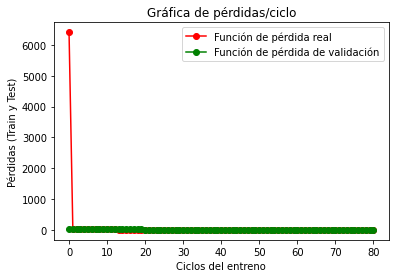

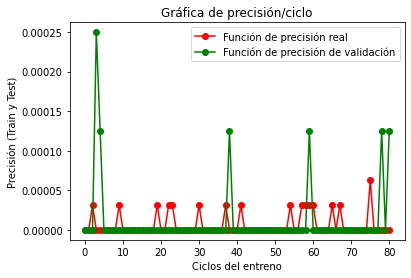

##################################################################
# MENÚ
# Indique a continuación el tipo de modelo a entrenar (0, 1 o 2):
# 0) Salir
# 1) Modelo CNN
# 2) Modelo LSTM
##################################################################
------------------------------------------------------------------
Indique una opción del menú: 0
Saliendo...


In [3]:
# Se cargan las librerías necesarias para la parte de: CLASIFICACIÓN DE LOS DATOS
import os
import shutil
import pandas as pd

# Función (en estado "beta") que clasifica unificando los ficheros que se especifican para el entreno (train)
# y los que son para pruebas (test). Recibe también la ruta donde se alojan los ficheros.
# Devuelve dos dataframe, pero solo se trabaja en el entreno con "df_train"
## COMO PROPUESTA FUTURA: que sea una función nativa con un funcionamiento similar al de la función "train_test_split"
##de la librería de scikit-learn
def clasificarDatos (train, test, ruta):
    
    # Se definen los dataframes donde se devolverá los resultados a entrenar
    df_train = []
    df_test = []
    
    # Ruta en mayúsculas
    ruta = ruta.upper()
    full_path = '/home/andreacc/DATOS/'
    path = "DATOS/"+ruta+"/"
    
    # Se convierte en minúsculas para poder trabajar correctamente con ellos
    train = [elem.lower() for elem in train]
    test = [elem.lower() for elem in test]
    
    # Se define un diccionario con un nombre en específico para cada fichero del estudio
    ## PROPUESTA DE MEJORA A FUTUROS, EVITAR EL DICCIONARIO, SOLO BUSCAR FICHEROS _new.csv
    names = {'03p': '03-Punto_new',
             '04p': '04-Punto_new',
             '05p': '05-Punto_new',
             '06p': '06-Punto_new',
             '07p': '07-Punto_new',
             '08p': '08-Punto_new',
             '01cp': '01-ControlPunto_new',
             '02cp': '02-ControlPunto_new',
             '03cp': '03-ControlPunto_new',
             '04cp': '04-ControlPunto_new',
             '05cp': '05-ControlPunto_new',
             '09cp': '09-ControlPunto_new',
             '16ti': '16-TEA-IMAGENES-TEST_TEA Imagenes_new', 
             '17ti': '17-TEA-IMAGENES-TEST_TEA Imagenes_new',
             '18ti': '18-TEA-IMAGENES-TEST_TEA Imagenes_new',
             '19ti': '19-TEA-IMAGENES-TEST_TEA Imagenes_new',
             '19tip': '19-TEA-IMAGENES-TEST_TEA Imagenes_Punto_new',
             '01ti': '01-TEA-IMAGENES-TEST_TEA Imagenes_new', #dudosos
             '02ti': '02-TEA-IMAGENES-TEST_TEA Imagenes_new', #dudosos
             '10ti': '10-TEA-IMAGENES-TEST_TEA Imagenes_new', #dudosos
             '11ti': '11-TEA-IMAGENES-TEST_TEA Imagenes_new'  #dudosos
            }
    
    # Se crea el fichero ALL donde se guardarán los archivos del entrenamiento (archivo_train.csv)
    # y de los test unificados (archivo_test.csv)
    os.mkdir(full_path+'ALL')
    
    # Para cada nombre de los ficheros del entrenamiento
    for name in train:
        # Si no se encuentra dicho nombre en el diccionario sale del programa.
        if not(name in names) :
            print ("El nombre de archivo "+ str(name) +" no existe")
            return
        else :
        # Se busca el archivo con el nombre especificado en el directorio.    
            archivo = names[name]
            archivo_ = path + archivo + '.csv'
            
            # Mientras el archivo esté abierto se leerá cada csv y se guardará en un nuevo csv todos los ficheros
            # además se guarda un dataframe con los datos para pasarlos a entrenar
            with open (archivo_, newline='') as file:
            
                data = pd.read_csv(file, sep=',', encoding='latin-1',index_col = 0)
                
                df_train.append(data)

                archivo_train = pd.concat(df_train)
                
                new_file = archivo_train.to_csv(full_path+'ALL/'+"archivo_train.csv")
                
    # Para cada nombre de los ficheros de las pruebas
    for name in test:
        # Si no se encuentra dicho nombre en el diccionario sale del programa.
        if not(name in names) :
            print ("El nombre de archivo "+ str(name) +" no existe")
            return
        else :
        # Se busca el archivo con el nombre especificado en el directorio.    
            archivo = names[name]
            archivo_ = path + archivo + '.csv'
            
            # Mientras el archivo esté abierto se leerá cada csv y se guardará en un nuevo csv todos los ficheros
            # además se guarda un dataframe con los datos para pasarlos como datos para validar y pruebas
            with open (archivo_, newline='') as file:
            
                data = pd.read_csv(file, sep=',', encoding='latin-1', index_col = 0)
                
                df_test.append(data)

                archivo_test = pd.concat(df_test)
            
                new_file = archivo_test.to_csv(full_path+'ALL/'+"archivo_test.csv")
                
    # Se devuelven los archivos de train y test como dataframes
    return archivo_train, archivo_test

df_train, df_test = clasificarDatos (['03p'], ['03p', '04p'], 'casos')

# Se llama al entrenamiento, y se entrena con el argumento "df_train"
entrenamiento(df_train, df_test)